# Nipams Perform Experiments & Collect Results

# 0. Initialize

In [1]:
#@title Connect to gDrive & Load Files
ENV_COLAB = 'google.colab' in str(get_ipython())
if ENV_COLAB:
    print('Running on CoLab')
    PROJECT_DRIVE_FOLDER= "/content/drive/MyDrive/NiPAMS/BP development/analysis/nipams-bp-py-main/" #@param {"type":"string"}
    ## Load this for local development version of library.. Loads from GoogleDrive (changes persist)
    from google.colab import drive, widgets, data_table; 
    drive.mount('/content/drive');
    %cd "$PROJECT_DRIVE_FOLDER"
  
    !pip install -qr requirements.txt
    !pip install -q envyaml
    import os, sys; 
    from envyaml import EnvYAML; env = EnvYAML('env/default.yml'); 
    for k,v in env.export().items(): os.environ[k]=str(v)
    sys.path.append(os.path.abspath("./src"))

else:
    print('Not running on CoLab')
    %cd /app
!pwd

from importlib import reload;
from utils.constants import *

Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main


# 1. Load Processed Data

In [2]:
import plotly.express as px
from data import load_data; reload(load_data)

# load_data.fetch_data_from_local(folder='data/raw_mat/', pattern='LLV')
# dfBpAll, dfImuAll = load_data.load_dataframe_from_mat(folder='data/raw_mat/', pattern='LLV')
dfAll = load_data.load_dataframe_from_pickle(folder='data/interim/', pattern='LLV')
dfImu = dfAll[INDICIES + INFO_COLS + IMU_COLS]
dfBp = dfAll[INDICIES + INFO_COLS + BP_COLS]

display('------ dfAll ------')
display("Unique Files : ", dfAll.file.nunique())
display(dfAll)

'------ dfAll ------'

'Unique Files : '

20

,file,ax,ay,az,gx,gy,gz,heartbeat,patient,test_type,test_num,tsCC,ts,pp,sbp,dbp
0,sub019_LLV1.mat,-1.213860,1.086967,-9.967060,1.235962,-0.991821,-0.381470,3.0,sub019,LLV,1,True,0 days 00:00:02.235000,69.087044,132.656695,63.569650
1,sub019_LLV1.mat,-1.209870,1.050456,-9.969455,1.022339,-0.549316,0.160217,3.0,sub019,LLV,1,True,0 days 00:00:02.240000,69.087044,132.656695,63.569650
2,sub019_LLV1.mat,-1.213860,1.091756,-9.914388,0.999451,-0.556946,-0.411987,3.0,sub019,LLV,1,True,0 days 00:00:02.245000,69.087044,132.656695,63.569650
3,sub019_LLV1.mat,-1.228225,1.089362,-9.861716,0.839233,0.000000,-0.045776,3.0,sub019,LLV,1,True,0 days 00:00:02.250000,69.087044,132.656695,63.569650
4,sub019_LLV1.mat,-1.197101,1.057439,-9.911994,0.701904,0.015259,-0.267029,3.0,sub019,LLV,1,True,0 days 00:00:02.255000,69.087044,132.656695,63.569650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134177,sub202_LLV2.mat,0.217872,0.349553,-9.915585,0.564575,0.480652,0.423431,65.0,sub202,LLV,2,True,0 days 00:00:51.722000,26.688227,113.289620,86.601392
134178,sub202_LLV2.mat,0.214281,0.345962,-9.947907,0.526428,0.556946,0.530243,65.0,sub202,LLV,2,True,0 days 00:00:51.727000,26.688227,113.289620,86.601392
134179,sub202_LLV2.mat,0.234632,0.387861,-9.852139,0.885010,0.770569,0.366211,65.0,sub202,LLV,2,True,0 days 00:00:51.732000,26.688227,113.289620,86.601392
134180,sub202_LLV2.mat,0.184354,0.385466,-9.931147,0.694275,0.701904,0.526428,65.0,sub202,LLV,2,True,0 days 00:00:51.737000,26.688227,113.289620,86.601392


In [3]:
px.line(dfAll.head(1000).select_dtypes(include=np.number).sort_values('ts').drop('ts',axis=1))

# 2. Experiments

In [89]:
import json
from models import experiments; reload(experiments)

<module 'models.experiments' from '/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main/src/models/experiments.py'>

In [162]:
# splitting_config = json.loads(experiments.DEFAULTS['split_by_random'])
splitting_config = json.loads(experiments.DEFAULTS['split_by_group'])
sampleRandTestInds = getattr(experiments, splitting_config['function'])(dfBp=dfBp, **splitting_config['kwargs'])

sampleRandTestInds = [{
    'train':x['train'].drop_duplicates(INDICIES),
    'test':x['test'].drop_duplicates(INDICIES)
} for x in sampleRandTestInds]
# sampleRandTestInds[0]['train'].drop_duplicates(INDICIES)

sampleExpDfs = experiments.get_experiment(sampleRandTestInds[0], dfImu, dfBp)

# 3. Modeling Pipelines (Baselines & Analytical)

In [163]:
from models import baselines, feature_models; reload(feature_models)

<module 'models.feature_models' from '/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main/src/models/feature_models.py'>

In [164]:
import sklearn
from data import preprocess;
from sklearn import pipeline, ensemble
from sklearn.pipeline import Pipeline

from features import simple as features_simple

pipe_mean = Pipeline([('transform', preprocess.TransformerTimeSeriesTo3D()),('baselines.DummyRegressor', baselines.DummyRegressor())])
pipe_random = Pipeline([('transform', preprocess.TransformerTimeSeriesTo3D()),('baselines.RandomRegressor', baselines.RandomRegressor())])

pipe_vect_simple = Pipeline([
    ('features_simple.vectorize_mean_std', preprocess.FunctionTransformer(partial(features_simple.vectorize_mean_std))),
    ('model_RandomForest', sklearn.ensemble.RandomForestRegressor())
])

In [165]:
dfResults = experiments.run_experiment("tmp", dfImu, dfBp, pipe_mean, sampleRandTestInds)
dfResults

mean_absolute_error, r2_score :  11.924 -3.444341369955616e+29
mean_absolute_error, r2_score :  5.459 -2.5124207598344803e+29
mean_absolute_error, r2_score :  4.015 -1.1568531707278311e+29
mean_absolute_error, r2_score :  8.362 0.0
mean_absolute_error, r2_score :  6.277 -2.6024934174096422e+29
mean_absolute_error, r2_score :  2.842 -1.3564637555398593e+28
mean_absolute_error, r2_score :  14.271 0.0
mean_absolute_error, r2_score :  10.982 -1.083525208262676e+30
mean_absolute_error, r2_score :  11.239 -8.62178074399405e+29
mean_absolute_error, r2_score :  7.524 -4.0840306486506164e+29
mean_absolute_error, r2_score :  11.737 -3.7872580379288826e+29
mean_absolute_error, r2_score :  17.508 0.0


,file,heartbeat,patient,test_type,test_num,pp,sbp,dbp,fold_number,dbp_actuals,dbp_preds,sbp_actuals,sbp_preds,pp_actuals,pp_preds,experiment_id,pipeline
0,sub019_LLV1.mat,3.0,sub019,LLV,1,69.087044,132.656695,63.569650,3.0,63.56965,66.106883,132.656695,109.435399,69.087044,43.328516,tmp,"transform, baselines.DummyRegressor"
1,sub019_LLV1.mat,4.0,sub019,LLV,1,74.280123,136.439737,62.159614,3.0,62.159614,66.106883,136.439737,109.435399,74.280123,43.328516,tmp,"transform, baselines.DummyRegressor"
2,sub019_LLV1.mat,5.0,sub019,LLV,1,68.054062,129.970574,61.916512,3.0,61.916512,66.106883,129.970574,109.435399,68.054062,43.328516,tmp,"transform, baselines.DummyRegressor"
3,sub019_LLV1.mat,6.0,sub019,LLV,1,71.280595,132.679622,61.399027,3.0,61.399027,66.106883,132.679622,109.435399,71.280595,43.328516,tmp,"transform, baselines.DummyRegressor"
4,sub019_LLV1.mat,7.0,sub019,LLV,1,70.994729,131.279738,60.285008,3.0,60.285008,66.106883,131.279738,109.435399,70.994729,43.328516,tmp,"transform, baselines.DummyRegressor"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,sub202_LLV2.mat,61.0,sub202,LLV,2,30.948687,110.391869,79.443182,3.0,79.443182,66.106883,110.391869,109.435399,30.948687,43.328516,tmp,"transform, baselines.DummyRegressor"
786,sub202_LLV2.mat,62.0,sub202,LLV,2,31.627355,110.945791,79.318436,3.0,79.318436,66.106883,110.945791,109.435399,31.627355,43.328516,tmp,"transform, baselines.DummyRegressor"
787,sub202_LLV2.mat,63.0,sub202,LLV,2,29.480493,110.431831,80.951338,3.0,80.951338,66.106883,110.431831,109.435399,29.480493,43.328516,tmp,"transform, baselines.DummyRegressor"
788,sub202_LLV2.mat,64.0,sub202,LLV,2,27.323251,111.827524,84.504274,3.0,84.504274,66.106883,111.827524,109.435399,27.323251,43.328516,tmp,"transform, baselines.DummyRegressor"


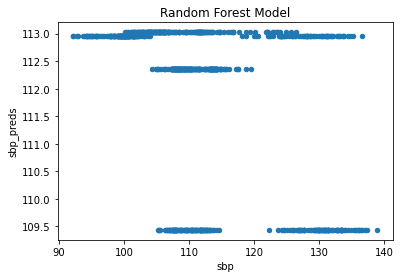

In [166]:
dfResults.plot.scatter('sbp','sbp_preds', title='Random Forest Model')

# ROUGH

In [167]:
STOP_HERE

NameError: ignored

In [ ]:
pipe = pipe_vect_simple
splits = sampleRandTestInds

rfResults1 = experiments.testPipeline(dfImu, dfBp, pipe, splits, targetCol='dbp', verbose=True)
dfBpInd = dfBp.groupby(INDICIES).last()
dfResults1 = create_results_df('dbp', dfBpInd, splits, rfResults1)

rfResults2 = experiments.testPipeline(dfImu, dfBp, pipe, splits, targetCol='sbp', verbose=True)
dfResults2 = create_results_df('sbp', dfBpInd, splits, rfResults2)

dfResults1\
    .merge(dfResults2, left_index=True, right_index=True, suffixes=('','_drop1'))\

In [ ]:
dfResults1\
    .merge(dfResults2, left_index=True, right_index=True, suffixes=('','_drop1'))\

In [ ]:
## create_results_df
target = 'dbp'
results = rfResults1
i=0

col_actual = f'{target}_actuals'
col_pred = f'{target}_preds'
dfTestRes = dfBpInd.copy().assign(fold_number=None, **{col_actual:None, col_pred:None})

df_bp = dfBpInd.loc[splits[i]['test'].set_index(INDICIES).index].reset_index()
dfPreds = pd.DataFrame([results[i]['y_test'].values,results[i]['preds']], index=[col_actual,f'{target}_preds']).T
dfPreds[INDICIES] = splits[i]['test'].reset_index()[INDICIES]


dfRes = pd.merge(df_bp.set_index(INDICIES), dfPreds.set_index(INDICIES), left_index=True, right_index=True,)#.drop_duplicates(INDICIES).set_index(INDICIES)

dfRes = dfRes.assign(fold_number=i)

dfRes

dfTestRes.update(dfRes.drop(columns=BP_COLS))

In [ ]:
display(splits[0]['test'])
display(dfPreds)
display(df_bp)
display("-------------------")

display(splits[0]['test'].drop_duplicates(INDICIES))
display(dfPreds.drop_duplicates(INDICIES))
display(df_bp.drop_duplicates(INDICIES))

# dfTestRes.index.is_unique
# dfTestRes.index.is_unique
# dfRes.index.is_unique




In [ ]:
# dfBp.set_index(INDICIES).loc[sampleRandTestInds[0]['test'].index]
df_bp = dfBp.set_index(INDICIES).loc[sampleRandTestInds[0]['test'].set_index(INDICIES).index].reset_index()
df_bp.groupby(INDICIES).last()

In [ ]:
rfResults1[0]['y_test']

In [ ]:
dfResults1